## AI Agent One

In [83]:
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
#from langchain_core.tracers import ConsoleCallbackHandler

from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.graph.message import add_messages

from typing import TypedDict, Annotated, Sequence
from dotenv import load_dotenv
import os

from IPython.display import Image, display

load_dotenv()
openai_api_key = os.getenv('OPENAI_API_KEY')

### Tools

In [66]:
@tool
def add(a:float, b:float)->float:
    """This is an addition function that can add two numbers togeather"""
    return a+b

@tool
def subt(a:float, b:float)->float:
    """This is an subtraction function that can subtract two numbers togeather"""
    return a-b

@tool
def mult(a:float, b:float)->float:
    """This is an multiplication function that can multiply two numbers togeather"""
    return a*b

@tool
def divide(a:float, b:float)->float:
    """This is an division function that can divide two numbers togeather"""
    return a/b

tools = [add, subt, mult, divide]

### LLM

In [67]:
#handler = ConsoleCallbackHandler()

llm = ChatOpenAI(
    model="o3-mini-2025-01-31",
    api_key=openai_api_key,
    #callbacks=[handler]
).bind_tools(tools)

In [68]:
response = llm.invoke('Can u divide 34.5 by 10')
response

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_6nBymoTAU3Ge18QYG8xp0YH5', 'function': {'arguments': '{"a": 34.5, "b": 10}', 'name': 'divide'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 100, 'prompt_tokens': 157, 'total_tokens': 257, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 64, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'o3-mini-2025-01-31', 'system_fingerprint': 'fp_e20469f047', 'id': 'chatcmpl-Bs66lUoGGWBOWARLaG9U16490ZwIF', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--97bdd643-93e1-4d1b-ad28-7bb137dc35b8-0', tool_calls=[{'name': 'divide', 'args': {'a': 34.5, 'b': 10}, 'id': 'call_6nBymoTAU3Ge18QYG8xp0YH5', 'type': 'tool_call'}], usage_metadata={'input_tokens': 157, 'output_tokens': 100, 'total_tokens': 257, 'input_token_details': {'audio'

In [69]:
print(response.tool_calls,'\n')
print(response.content,'\n')
print(response.usage_metadata)

[{'name': 'divide', 'args': {'a': 34.5, 'b': 10}, 'id': 'call_6nBymoTAU3Ge18QYG8xp0YH5', 'type': 'tool_call'}] 

 

{'input_tokens': 157, 'output_tokens': 100, 'total_tokens': 257, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 64}}


### State & Node Functions

In [84]:
class AgentState(TypedDict):
    query : str
    messages : Annotated[Sequence[BaseMessage], add_messages]

def setup_node(state:AgentState)->AgentState:
    state['messages'] = [ 
        SystemMessage(content="You are agent who helps people to do arithmatic operations with the help of tools provided."),
        HumanMessage(content=state['query'])
    ]
    #print(f"setup:{state}")
    return state

def agent_node(state:AgentState)->AgentState:
    response = llm.invoke(state['messages'])
    state['messages'].append(response)
    #print(f"agent : {state}")
    #return {'messages' : response}
    return response

def decision_node(state:AgentState)->AgentState:
    last_message = state['messages'][-1]
    #
    if last_message.tool_calls:
        return 'tools call'
    else:
        return 'exit'

### Graph

In [85]:
#graph init
graph = StateGraph(state_schema=AgentState)

#nodes
tools_node = ToolNode(tools)
graph.add_node(node='setup', action=setup_node)
graph.add_node(node='agent', action=agent_node)
graph.add_node(node='tools', action=tools_node)

#edges
graph.add_edge(START, 'setup')
graph.add_edge('setup', 'agent')
graph.add_edge('tools', 'agent')

#condiotional agents
graph.add_conditional_edges(source='agent',
                            path=decision_node,
                            path_map={
                                'tools call':'tools',
                                'exit':END
                            })

#
app = graph.compile()

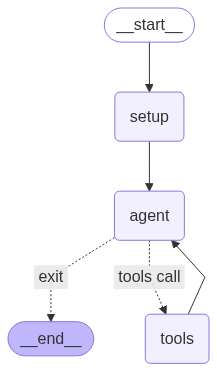

In [86]:
display(Image(app.get_graph().draw_mermaid_png()))

In [87]:
app.invoke({'query': "Can u add 12 to 50 and then divide it by 20"})

{'query': 'Can u add 12 to 50 and then divide it by 20',
 'messages': [SystemMessage(content='You are agent who helps people to do arithmatic operations with the help of tools provided.', additional_kwargs={}, response_metadata={}, id='08812bf2-1bed-430a-a1cc-07f937456acc'),
  HumanMessage(content='Can u add 12 to 50 and then divide it by 20', additional_kwargs={}, response_metadata={}, id='75884b1a-ee3e-4140-912f-fbc3d9e227d6'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_pSbyy1nMTwyhdohEy4f6gOCH', 'function': {'arguments': '{"a": 12, "b": 50}', 'name': 'add'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 418, 'prompt_tokens': 184, 'total_tokens': 602, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 384, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'o3-mini-2025-01-31', 'system_fingerpr

In [100]:
response = app.stream({'query': "Can u add 12 to 50 and then divide it by 20"}, stream_mode='values') #stream intead of invoke generates a generator

In [102]:
for res in response:
    #print(res)
    message = res['messages'][-1] if res['messages'] else ()
    if isinstance(message, tuple):
        print(message)
    else:
        message.pretty_print()


================================ Human Message =================================

Can u add 12 to 50 and then divide it by 20
================================= Tool Message =================================
Name: add

62.0
================================= Tool Message =================================
Name: divide

3.1
